## Gas Sensor Array Drift - Modeling

In [103]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import time

from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt


In [104]:
seed = 10

### Load the data

In [270]:
dataset = pd.read_csv('dataset_Update.csv')

In [271]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
5,13910.0,0.860626,0.193857,-1.0,0.823641,0.949260,0.982944,1.0
8,13910.0,-0.716549,0.247125,-1.0,-0.886531,-0.792084,-0.666539,1.0
72,13910.0,-0.830847,0.191891,-1.0,-0.957677,-0.897835,-0.774411,1.0
2,13910.0,-0.845145,0.210798,-1.0,-0.980449,-0.940423,-0.794241,1.0
13,13910.0,0.766762,0.250268,-1.0,0.695296,0.844533,0.948475,1.0
7,13910.0,0.803146,0.147210,-1.0,0.815994,0.854705,0.864624,1.0
16,13910.0,-0.177983,0.244992,-1.0,-0.365460,-0.213577,-0.031182,1.0
64,13910.0,-0.782629,0.219460,-1.0,-0.943115,-0.840547,-0.704652,1.0
77,13910.0,0.851055,0.187107,-1.0,0.786508,0.923823,0.976793,1.0
122,13910.0,-0.556813,0.325995,-1.0,-0.810192,-0.639391,-0.365291,1.0


In [272]:
# drop rows with missing values
dataset.dropna(inplace=True)
print(dataset.shape)

(13910, 11)


In [273]:
dataset.isnull().sum()

5      0
8      0
72     0
2      0
13     0
7      0
16     0
64     0
77     0
122    0
128    0
dtype: int64

In [275]:
last_column = dataset.iloc[:, -1].nunique()
print(last_column)

6


In [276]:
print(dataset.shape)
dataset.head()

(13910, 11)


,5,8,72,2,13,7,16,64,77,122,128
0,0.958387,-0.878662,-0.929810,-0.971612,0.944146,0.865034,-0.465786,-0.923203,0.945019,-0.967450,1
1,0.928190,-0.845751,-0.894518,-0.935227,0.905480,0.862033,-0.442325,-0.893253,0.906726,-0.939320,1
2,0.883323,-0.792863,-0.841604,-0.901866,0.849213,0.856738,-0.408138,-0.842800,0.849250,-0.912999,1
3,0.880565,-0.789712,-0.837996,-0.854993,0.844932,0.857085,-0.403969,-0.838813,0.844962,-0.877101,1
4,0.831314,-0.737248,-0.784567,-0.862880,0.784718,0.852045,-0.365080,-0.787939,0.782513,-0.876364,1


In [277]:
dataset.columns

Index(['5', '8', '72', '2', '13', '7', '16', '64', '77', '122', '128'], dtype='object')

## Correlation

In [278]:
cor = dataset.corr()
cor

,5,8,72,2,13,7,16,64,77,122,128
5,1.000000,-0.849942,-0.871938,-0.944900,0.913765,0.730038,-0.375899,-0.848220,0.924203,-0.339167,-0.171022
8,-0.849942,1.000000,0.948527,0.908774,-0.924494,-0.673588,0.477190,0.974413,-0.861214,0.436841,0.350533
72,-0.871938,0.948527,1.000000,0.911381,-0.887320,-0.627280,0.450477,0.986257,-0.929002,0.432506,0.173878
2,-0.944900,0.908774,0.911381,1.000000,-0.869985,-0.682115,0.443285,0.902202,-0.860184,0.419206,0.206746
13,0.913765,-0.924494,-0.887320,-0.869985,1.000000,0.753186,-0.439279,-0.904952,0.941416,-0.411451,-0.277772
7,0.730038,-0.673588,-0.627280,-0.682115,0.753186,1.000000,-0.394256,-0.644648,0.698709,-0.380154,-0.193041
16,-0.375899,0.477190,0.450477,0.443285,-0.439279,-0.394256,1.000000,0.461459,-0.403999,0.922184,-0.196012
64,-0.848220,0.974413,0.986257,0.902202,-0.904952,-0.644648,0.461459,1.000000,-0.903980,0.453358,0.241435
77,0.924203,-0.861214,-0.929002,-0.860184,0.941416,0.698709,-0.403999,-0.903980,1.000000,-0.393382,-0.099466
122,-0.339167,0.436841,0.432506,0.419206,-0.411451,-0.380154,0.922184,0.453358,-0.393382,1.000000,-0.286350


## Heatmap

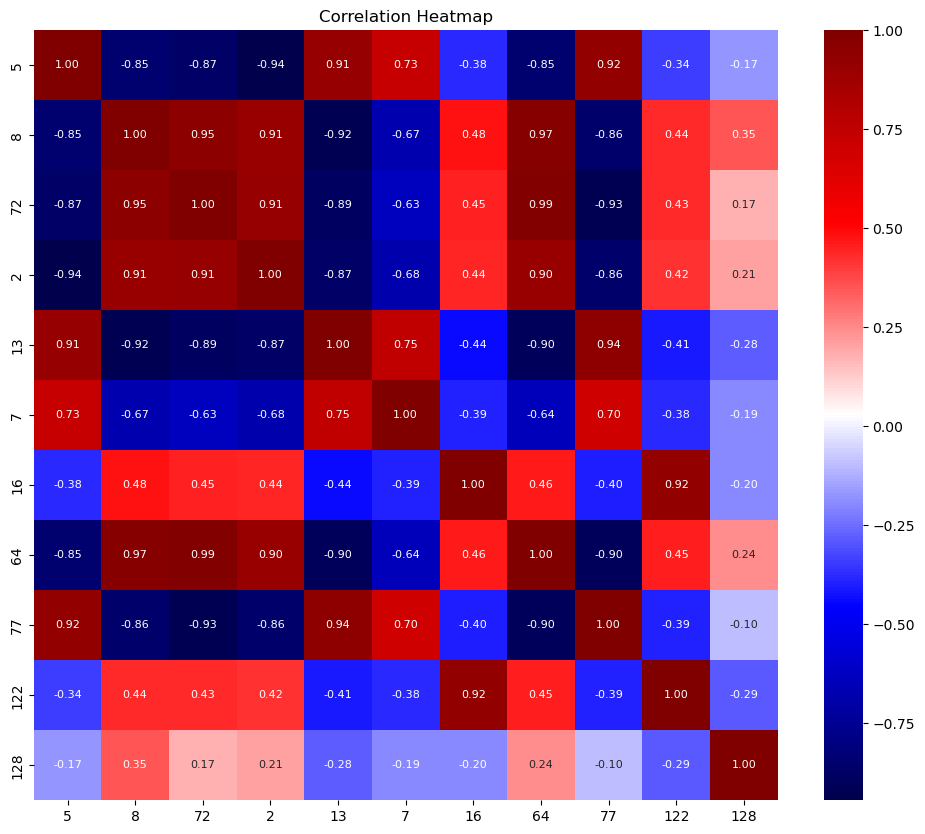

In [279]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))  # Increase figure size for better readability
sns.heatmap(cor, annot=True, cmap='seismic', fmt='.2f', annot_kws={"size": 8})  # Reduce annotation size
plt.title('Correlation Heatmap', fontsize=12)  # Reduce title font size
plt.show()


In [280]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13910 entries, 0 to 13909
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   5       13910 non-null  float64
 1   8       13910 non-null  float64
 2   72      13910 non-null  float64
 3   2       13910 non-null  float64
 4   13      13910 non-null  float64
 5   7       13910 non-null  float64
 6   16      13910 non-null  float64
 7   64      13910 non-null  float64
 8   77      13910 non-null  float64
 9   122     13910 non-null  float64
 10  128     13910 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.2 MB


## Data Separation

In [281]:

# Define X and y
X = dataset.iloc[:, 1:]  # All columns except the first one
y = dataset.iloc[:, 0]   # The first column

# Verify the shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (13910, 10)
Shape of y: (13910,)


In [282]:
X.shape

(13910, 10)

In [283]:
y.shape

(13910,)

In [284]:
X.head(1)

,8,72,2,13,7,16,64,77,122,128
0,-0.878662,-0.92981,-0.971612,0.944146,0.865034,-0.465786,-0.923203,0.945019,-0.96745,1


In [285]:
y.head(1)

0    0.958387
Name: 5, dtype: float64

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

In [287]:
X_train.shape, X_test.shape

((11128, 10), (2782, 10))

## Best Parameter Selection for ML ALgorithm /Regression


In [288]:
kfold = StratifiedKFold(n_splits=10, random_state=20, shuffle=True)

In [289]:
X_train.shape

(11128, 10)

In [290]:
y_train.shape

(11128,)

In [291]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [297]:
# Verify shapes of scaled data
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (11128, 10)
X_test_scaled shape: (2782, 10)


## 1. MLP regression Model

In [293]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 100)],  # Different hidden layer configurations
    'activation': ['relu', 'tanh'],  # Activation functions to try
    'alpha': [0.0001, 0.001, 0.01],   # Regularization parameter
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
}

# Perform grid search with cross-validation (default 5 folds)
mlp_regressor = MLPRegressor(max_iter=500, random_state=42)
grid_search = GridSearchCV(mlp_regressor, param_grid, cv=10, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant'}


In [294]:
# Train the MLPRegressor model with the best parameters
best_mlp_regressor = MLPRegressor(max_iter=500, random_state=42, **best_params)

training_start = time.perf_counter()
best_mlp_regressor.fit(X_train_scaled, y_train)
training_end = time.perf_counter()

# Evaluate the model
prediction_start = time.perf_counter()
y_pred_inverse = best_mlp_regressor.predict(X_test_scaled)
prediction_end = time.perf_counter()

mse_inverse = mean_squared_error(y_test, y_pred_inverse)
r2_inverse = r2_score(y_test, y_pred_inverse)
mlp_train_time = training_end - training_start
mlp_prediction_time = prediction_end - prediction_start


print(f"Inverse Model MSE: {mse_inverse:.4f}")
print(f"Inverse Model R^2: {r2_inverse:.4f}")
print("Time consumed for training: %4.3f seconds" % (mlp_train_time))
print("Time consumed for prediction: %6.5f seconds" % (mlp_prediction_time))

Inverse Model MSE: 0.0004
Inverse Model R^2: 0.9886
Time consumed for training: 0.671 seconds
Time consumed for prediction: 0.00226 seconds


In [314]:
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already defined and fitted
# scaler and inverse_model are already fitted as per your previous steps

# Define new sensor measurements
new_sensor_measurements = np.array([[-0.8786617750623564,-0.9298098764878306,-0.971612294066858,0.9441460091933315,0.8650336288267729,-0.4657861086935119,
-0.9232031210534897,0.9450192060341563,-0.9674504911637175,1]])
new_sensor_measurements = new_sensor_measurements.reshape(1, -1)

# Scale the new sensor measurements using the previously fitted scaler
new_sensor_scaled = scaler.transform(new_sensor_measurements)

# Predict the true measurements using the inverse model
predicted_X = best_mlp_regressor.predict(new_sensor_scaled)

print("Predicted True Measurements:", predicted_X)
print("Actual Value:", 0.9583867868533383)

Predicted True Measurements: [0.97314647]
Actual Value: 0.9583867868533383


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


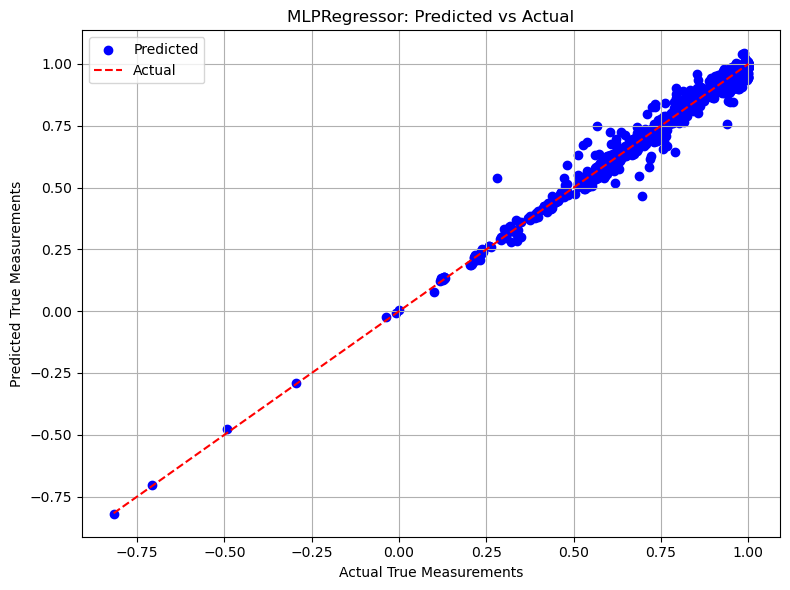

Predicted True Measurements: [0.97314647]
Actual Value: 0.9583867868533383


In [317]:
# Actual value for comparison
actual_value = 0.9583867868533383

# Plotting predicted versus actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_inverse, color='blue', label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Actual')
plt.title('MLPRegressor: Predicted vs Actual')
plt.xlabel('Actual True Measurements')
plt.ylabel('Predicted True Measurements')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot as 'best_model.png'
plt.savefig('best_model.png')

# Show the plot
plt.show()

print("Predicted True Measurements:", predicted_X)
print("Actual Value:", actual_value)

## 2. ElasticNet

In [300]:
param_grid_elasticnet = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],  # Regularization parameter
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],     # L1 ratio (0 for L2 regularization, 1 for L1 regularization)
}

# Perform grid search with cross-validation (default 5 folds)
elasticnet_regressor = ElasticNet(random_state=42)
grid_search_elasticnet = GridSearchCV(elasticnet_regressor, param_grid_elasticnet, cv=10, scoring='r2', n_jobs=-1)
grid_search_elasticnet.fit(X_train_scaled, y_train)

# Get the best parameters
best_params_elasticnet = grid_search_elasticnet.best_params_
print(f"Best parameters found: {best_params_elasticnet}")


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e-01, tolerance: 3.846e-02
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.043e-02, tolerance: 3.826e-02
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.997e-02, tolerance: 3.819e

Best parameters found: {'alpha': 0.0001, 'l1_ratio': 0.1}


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.092e-02, tolerance: 4.299e-02
  model = cd_fast.enet_coordinate_descent(


In [301]:
best_elasticnet_regressor = ElasticNet(random_state=42, **best_params_elasticnet)

training_start_elasticnet = time.perf_counter()
best_elasticnet_regressor.fit(X_train_scaled, y_train)
training_end_elasticnet = time.perf_counter()

# Evaluate the model
prediction_start_elasticnet = time.perf_counter()
y_pred_test_elasticnet = best_elasticnet_regressor.predict(X_test_scaled)
prediction_end_elasticnet = time.perf_counter()

mse_test_elasticnet = mean_squared_error(y_test, y_pred_test_elasticnet)
r2_test_elasticnet = r2_score(y_test, y_pred_test_elasticnet)
elasticnet_train_time = training_end_elasticnet - training_start_elasticnet
elasticnet_pred_time = prediction_end_elasticnet - prediction_start_elasticnet

# Print evaluation metrics
print(f"ElasticNet Testing MSE: {mse_test_elasticnet:.4f}")
print(f"ElasticNet Testing R^2: {r2_test_elasticnet:.4f}")
print(f"ElasticNet Training Time: {elasticnet_train_time:.4f} seconds")
print(f"ElasticNet Prediction Time: {elasticnet_pred_time:.5f} seconds")


ElasticNet Testing MSE: 0.0008
ElasticNet Testing R^2: 0.9748
ElasticNet Training Time: 0.0826 seconds
ElasticNet Prediction Time: 0.00054 seconds


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.092e-02, tolerance: 4.299e-02
  model = cd_fast.enet_coordinate_descent(


In [313]:
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already defined and fitted
# scaler and inverse_model are already fitted as per your previous steps

new_sensor_measurements = np.array([[-0.8786617750623564,-0.9298098764878306,-0.971612294066858,0.9441460091933315,0.8650336288267729,-0.4657861086935119,
-0.9232031210534897,0.9450192060341563,-0.9674504911637175,1]])
new_sensor_measurements = new_sensor_measurements.reshape(1, -1)


# Scale the new sensor measurements using the previously fitted scaler
new_sensor_scaled = scaler.transform(new_sensor_measurements)

# Predict the true measurements using the inverse model
predicted_X = best_elasticnet_regressor.predict(new_sensor_scaled)

print("Predicted True Measurements:", predicted_X)
print("Actual Value:", 0.9583867868533383)

Predicted True Measurements: [0.95499576]
Actual Value: 0.9583867868533383


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


## 3. SVM

In [307]:
X_train_scaled.shape

(11128, 10)

In [308]:
# Define the hyperparameter grid for grid search
param_grid = {
    'C': [2**i for i in range(-5, 11)],  # 2^-5 to 2^10
    'gamma': [2**i for i in range(-10, 6)]  # 2^-10 to 2^5
}

# Perform grid search with cross-validation (10 folds)
svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=10, scoring='r2', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Best parameters found: {'C': 512, 'gamma': 0.015625}


In [309]:
# Train the SVR model with the best parameters
best_svr = SVR(kernel='rbf', C=512, gamma=0.015625)

training_start = time.perf_counter()
best_svr.fit(X_train_scaled, y_train)
training_end = time.perf_counter()

training_end = time.perf_counter()

# Evaluate the model
prediction_start = time.perf_counter()
y_pred_test_svr = best_svr.predict(X_test_scaled)
prediction_end = time.perf_counter()


mse_test_svr = mean_squared_error(y_test, y_pred_test_svr)
r2_test_svr = r2_score(y_test, y_pred_test_svr)
svm_train_time = training_end - training_start
svm_prediction_time = prediction_end - prediction_start

print(f"SVR Testing MSE: {mse_test_svr:.4f}")
print(f"SVR Testing R^2: {r2_test_svr:.4f}")
print("Time consumed for training: %4.3f seconds" % (svm_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svm_prediction_time))

SVR Testing MSE: 0.0013
SVR Testing R^2: 0.9611
Time consumed for training: 0.258 seconds
Time consumed for prediction: 0.00884 seconds


In [312]:
import numpy as np

# Define new sensor measurements
new_sensor_measurements = np.array([[-0.8786617750623564, -0.9298098764878306, -0.971612294066858, 0.9441460091933315,
                                     0.8650336288267729, -0.4657861086935119, -0.9232031210534897, 0.9450192060341563,
                                     -0.9674504911637175, 1]])

# Reshape to ensure it's 2D
new_sensor_measurements = new_sensor_measurements.reshape(1, -1)

# Scale the new sensor measurements using the previously fitted scaler
new_sensor_scaled = scaler.transform(new_sensor_measurements)

# Predict the true measurements using the SVR model
predicted_X = best_svr.predict(new_sensor_scaled)

# Print predicted and actual values
print("Predicted True Measurements:", predicted_X[0])  # Assuming predicted_X is a single-element array
print("Actual Value:", 0.9583867868533383)  # Replace with your actual value if it varies



Predicted True Measurements: 0.9160786199210283
Actual Value: 0.9583867868533383


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


## 4. Random Forest Regressor

In [319]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}
rf_regressor = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf_regressor, param_grid_rf, cv=10, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print(f"Best parameters found: {best_params_rf}")

# Initialize the best Random Forest regressor with the best parameters
best_rf_regressor = RandomForestRegressor(random_state=42, **best_params_rf)


/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
645 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.11/site-packages/sklearn/base.py

Best parameters found: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [320]:
training_start_rf = time.perf_counter()
best_rf_regressor.fit(X_train_scaled, y_train)
training_end_rf = time.perf_counter()

# Evaluate the model
prediction_start_rf = time.perf_counter()
y_pred_test_rf = best_rf_regressor.predict(X_test_scaled)
prediction_end_rf = time.perf_counter()

mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)
rf_train_time = training_end_rf - training_start_rf
rf_pred_time = prediction_end_rf - prediction_start_rf

# Print evaluation metrics
print(f"Random Forest Testing MSE: {mse_test_rf:.4f}")
print(f"Random Forest Testing R^2: {r2_test_rf:.4f}")
print(f"Random Forest Training Time: {rf_train_time:.4f} seconds")
print(f"Random Forest Prediction Time: {rf_pred_time:.5f} seconds")

Random Forest Testing MSE: 0.0002
Random Forest Testing R^2: 0.9943
Random Forest Training Time: 3.0521 seconds
Random Forest Prediction Time: 0.07438 seconds


In [321]:
import numpy as np

# Define new sensor measurements
new_sensor_measurements = np.array([[-0.8786617750623564, -0.9298098764878306, -0.971612294066858, 0.9441460091933315,
                                     0.8650336288267729, -0.4657861086935119, -0.9232031210534897, 0.9450192060341563,
                                     -0.9674504911637175, 1]])

# Reshape to ensure it's 2D
new_sensor_measurements = new_sensor_measurements.reshape(1, -1)

# Scale the new sensor measurements using the previously fitted scaler
new_sensor_scaled = scaler.transform(new_sensor_measurements)

# Predict the true measurements using the SVR model
predicted_X = best_rf_regressor.predict(new_sensor_scaled)

# Print predicted and actual values
print("Predicted True Measurements:", predicted_X[0])  # Assuming predicted_X is a single-element array
print("Actual Value:", 0.9583867868533383)  # Replace with your actual value if it varies



Predicted True Measurements: 0.9635748277042498
Actual Value: 0.9583867868533383


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


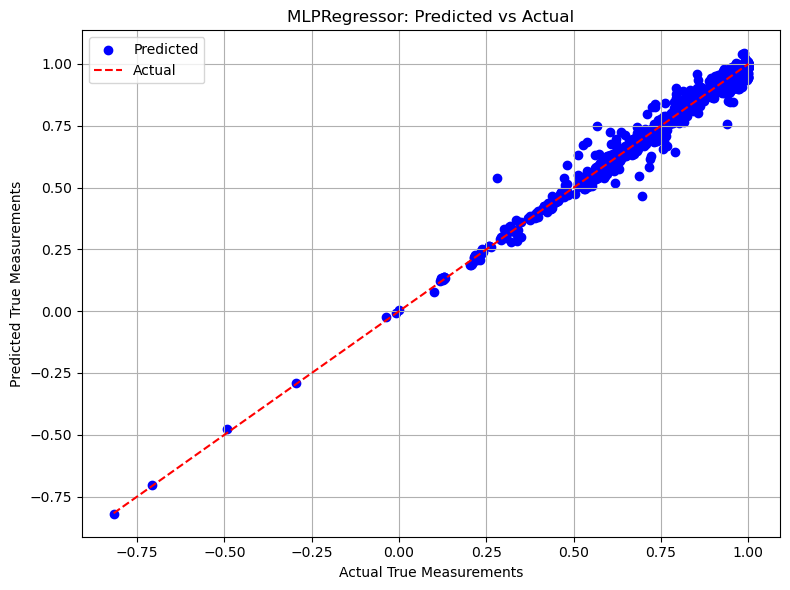

Predicted True Measurements: [0.96357483]
Actual Value: 0.9583867868533383


In [322]:
# Actual value for comparison
actual_value = 0.9583867868533383

# Plotting predicted versus actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_inverse, color='blue', label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Actual')
plt.title('MLPRegressor: Predicted vs Actual')
plt.xlabel('Actual True Measurements')
plt.ylabel('Predicted True Measurements')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot as 'best_model.png'
plt.savefig('best_model.png')

# Show the plot
plt.show()

print("Predicted True Measurements:", predicted_X)
print("Actual Value:", actual_value)

## Report

| Model           | MSE    | R^2    | Training Time (s) | Prediction Time (s) | Predicted True Measurements |
|-----------------|--------|--------|--------------------|----------------------|-----------------------------|
| MLP Regression  | 0.0004 | 0.9886 | 0.671              | 0.00226              | 0.97314647                  |
| ElasticNet      | 0.0008 | 0.9748 | 0.0826             | 0.00054              | 0.95499576                  |
| SVR             | 0.0013 | 0.9611 | 0.258              | 0.00884              | 0.91607862 
|RandomForestRegre| 0.0002 |0.9943  | 3.0521             | 0.07438              | 0.96357482                  |
